In [65]:
import gym
import time
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# CartPole game
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

# Test game

In [6]:
env = gym.make('CartPole-v0')
env.seed(6)
env = env.unwrapped
env.reset()

for i in range(20):
    env.render()
    observation, reward, done, info = env.step(action=0) # action is 0 for left, 1 for right
    print('Obs:{}, R:{}, Done:{}'.format(observation, reward, done))
    if(done):
        break
    time.sleep(1)

env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Obs:[-0.01447798 -0.14663955  0.00447863  0.27486761], R:1.0, Done:False
Obs:[-0.01741077 -0.34182511  0.00997599  0.56895973], R:1.0, Done:False
Obs:[-0.02424727 -0.53708555  0.02135518  0.86476871], R:1.0, Done:False
Obs:[-0.03498898 -0.73249158  0.03865056  1.16408886], R:1.0, Done:False
Obs:[-0.04963882 -0.92809483  0.06193233  1.46863504], R:1.0, Done:False
Obs:[-0.06820071 -1.12391758  0.09130503  1.78000249], R:1.0, Done:False
Obs:[-0.09067906 -1.31994063  0.12690508  2.09961869], R:1.0, Done:False
Obs:[-0.11707788 -1.51608886  0.16889746  2.42868504], R:1.0, Done:False
Obs:[-0.14739965 -1.71221442  0.21747116  2.76810739], R:1.0, Done:True


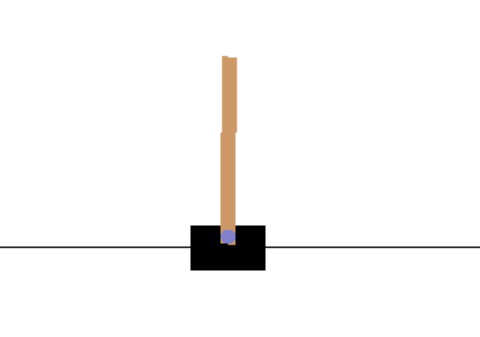
- Observation : [x, x_dot(speed), theta, theta_dot(ang_speed)]
- Reward : 1 for each step
- Done : whether cart state is out of threshold (x:+-2.4, theta:+-12*(2*pi/360)~=+-0.21)

# Target 
Learn a model by input Observation(4 dimension) and output Action({0,1}) to control the cart to prevent the pole from falling as longer as possible.

# Define a general policy gradient model
An actor will decide action when given environment observation (state)  
If actor has parameters - theta, we can use gradient asscent to maximize expected total reward by tunning theta.

theta = theta + learning_rate * G_theta(R_exp)
- G_theta() : gradient of theta
- R_exp : expected total reward
  
  
G_theta(R_exp) = 1/N x (Sum_N(Sum_T(R_n x G_theta(log(P_a(s_t))))))
- P_a(s_t) : probability of real action given state at time t 
- R_n : total reward of n-th episode
- Sum_N : sum for total episodes
- Sum_T : sum for each step of one episode

If we update theta for each episode  
G_theta(R) = Sum_T(R x G_theta(log(P_a(s_t))))
- R : total reward of one episode

Maximize(R) = Maximize(Sum_T(R x log(P_a(s_t)))) = Minimize(Sum_T(R x -log(P_a(s_t))))
- -log(P_a(s_t)) : cross entropy
- Sum_T(R x -log(P_a(s_t))) : loss

Use state value Vt instead of total reward R
V_t-1 = r_t + V_t * gamma
- gamma : discount rate (0~1)

In [56]:
class Policy_Gradient:
    
    def __init__(
        self, 
        n_actions, # actions dimension
        n_states,  # states dimension
    ):
    
        self.n_actions = n_actions
        self.n_states = n_states
        
        self.past_state, self.past_action, self.past_reward = [], [], []
        
        # setup tensorflow graph
        tf.reset_default_graph()
        
        # actor input : state
        self.state_input = tf.placeholder(shape = [None, self.n_states], 
                                          name = 'state_input',
                                          dtype = tf.float32)

        # actor output : action
        self.real_action = tf.placeholder(shape = [None, self.n_actions], 
                                          name = 'real_action',
                                          dtype = tf.float32)

        # reward of a state
        self.Vt = tf.placeholder(shape= [None, ], 
                                            name="Vt",
                                            dtype = tf.float32)

        # Create Actor (NN model)
        with tf.variable_scope('Actor'):
            self.act_proba = self.build_network(neuron_num=10, Trainable = True, scope = 'net_eval') 
            
        # get NN parameters for training
        self.Actor_eval_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/net_eval')
        
        # loss
        self.cross_entropy = -tf.reduce_sum(tf.log(self.act_proba) * self.real_action, axis=1)
        self.loss = tf.reduce_sum(self.cross_entropy * self.Vt)
        
        self.train = tf.train.RMSPropOptimizer(learning_rate=0.01).minimize(self.loss, var_list=self.Actor_eval_params)
    
        # initial session
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
    
    # store past states, rewards, actions of an episode 
    def write_memory(self, current_state, reward, action):
        self.past_state.append(current_state)
        
        action_one_hot = np.zeros(self.n_actions, dtype=np.int32)
        action_one_hot[action] = 1
        self.past_action.append(action_one_hot)
        
        self.past_reward.append(reward)
    
    
    def build_network(self, neuron_num, Trainable, scope): 
        with tf.variable_scope(scope):
            init_w = tf.random_normal_initializer(0., 0.3)
            init_b = tf.constant_initializer(0.1)
            
            x_h1 = tf.layers.dense(inputs = self.state_input, units = neuron_num, \
                   activation = tf.nn.tanh, kernel_initializer=init_w, \
                   bias_initializer=init_b, trainable=Trainable) 
            x_h2 = tf.layers.dense(inputs = self.state_input, units = neuron_num, \
                   activation = tf.nn.tanh, kernel_initializer=init_w, \
                   bias_initializer=init_b, trainable=Trainable)
            
            # output probabilities of actions
            output = tf.layers.dense(inputs = x_h2, units = self.n_actions, \
                   activation = tf.nn.softmax, kernel_initializer=init_w, \
                   bias_initializer=init_b, trainable=Trainable)
            
        return output
               
 
            
    def choose_action(self, current_state):
        act_proba = self.sess.run(self.act_proba, feed_dict={self.state_input: current_state[np.newaxis, :]})
        # choose action by its probability
        self.action = np.random.choice(range(act_proba.shape[1]), p=act_proba.ravel())  
   
        return self.action
    
    def learn(self): #####
        Vt = self.calculate_Vt(self.past_reward)
        
        # learn with one episode
        self.sess.run(self.train, feed_dict={
             self.state_input: np.array(self.past_state),  # shape=[None, n_state]
             self.real_action: np.array(self.past_action),  # shape=[None, n_actions]
             self.Vt: np.array(Vt)  # shape=[None, ]
        })
        
        # clear memory
        self.past_state, self.past_action, self.past_reward = [], [], []    
    
    def calculate_Vt(self, reward): 
        # discount episode rewards
        gamma = 0.99
        Vt = np.zeros_like(reward, dtype=np.float64)
        Vt_temp = 0
        for t in reversed(range(0, len(reward))):
            Vt_temp = reward[t] + Vt_temp * gamma
            Vt[t] = Vt_temp

        # normalize episode rewards, make loss value be more stable
        Vt -= np.mean(Vt)
        Vt /= np.std(Vt)
        
        return Vt    
        
    def model_save(self, model_name):
        saver = tf.train.Saver()
        saver.save(self.sess, "saved_models/{}.ckpt".format(model_name))
    
    def model_restore(self, model_name):
        saver = tf.train.Saver()
        saver.restore(self.sess, "saved_models/{}.ckpt".format(model_name))

In [57]:
def training(save_model, model_name):
    step_record = []
    reward_record = []
    
    for episode in range(200):
        current_state = env.reset()
        
        step = 0
        total_reward = 0

        while True:
            
            env.render() # render window

            action = RL.choose_action(current_state)

            # input action to environment
            next_state, reward, done, _ = env.step(action)
            
            total_reward+= reward
            
            # set max step to avoid never end
            if step > 10000: 
                done = True
            
            RL.write_memory(current_state, reward, action)

            # swap state
            current_state = next_state

            # break while loop when end of this episode
            if done:
                RL.learn()
                print('episode:{} steps:{} total reward:{}'.format(episode, step, total_reward))
                step_record.append(step)
                reward_record.append(total_reward)
                break
            step += 1

    # end of game
    if save_model:
        RL.model_save(model_name)
        
    print('game over')
    env.close()
    
    return step_record, reward_record

In [58]:
RL = Policy_Gradient(n_actions = 2, n_states = 4)

In [59]:
env = gym.make('CartPole-v0')
env.seed(1)     # reproducible, general Policy gradient has high variance
env = env.unwrapped

step_record, reward_record = training(save_model = True, model_name='PG_CartPole')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode:0 steps:18 total reward:19.0
episode:1 steps:8 total reward:9.0
episode:2 steps:18 total reward:19.0
episode:3 steps:13 total reward:14.0
episode:4 steps:41 total reward:42.0
episode:5 steps:21 total reward:22.0
episode:6 steps:24 total reward:25.0
episode:7 steps:44 total reward:45.0
episode:8 steps:31 total reward:32.0
episode:9 steps:36 total reward:37.0
episode:10 steps:19 total reward:20.0
episode:11 steps:17 total reward:18.0
episode:12 steps:17 total reward:18.0
episode:13 steps:28 total reward:29.0
episode:14 steps:27 total reward:28.0
episode:15 steps:19 total reward:20.0
episode:16 steps:72 total reward:73.0
episode:17 steps:21 total reward:22.0
episode:18 steps:21 total reward:22.0
episode:19 steps:13 total reward:14.0
episode:20 steps:29 total reward:30.0
episode:21 steps:12 total reward:13.0
episode:22 steps:10 total reward:11.0
episode:23 steps:17 total reward:18.0
e

game over


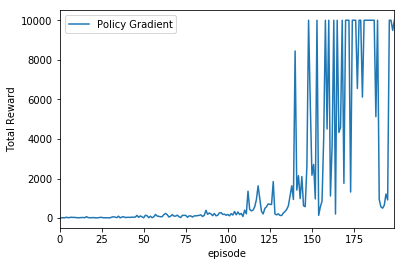

In [67]:
reward_result = pd.DataFrame(reward_record)
reward_result.columns = ['Policy Gradient']
reward_result.plot()
plt.xlabel('episode')
plt.ylabel('Total Reward')
plt.show()